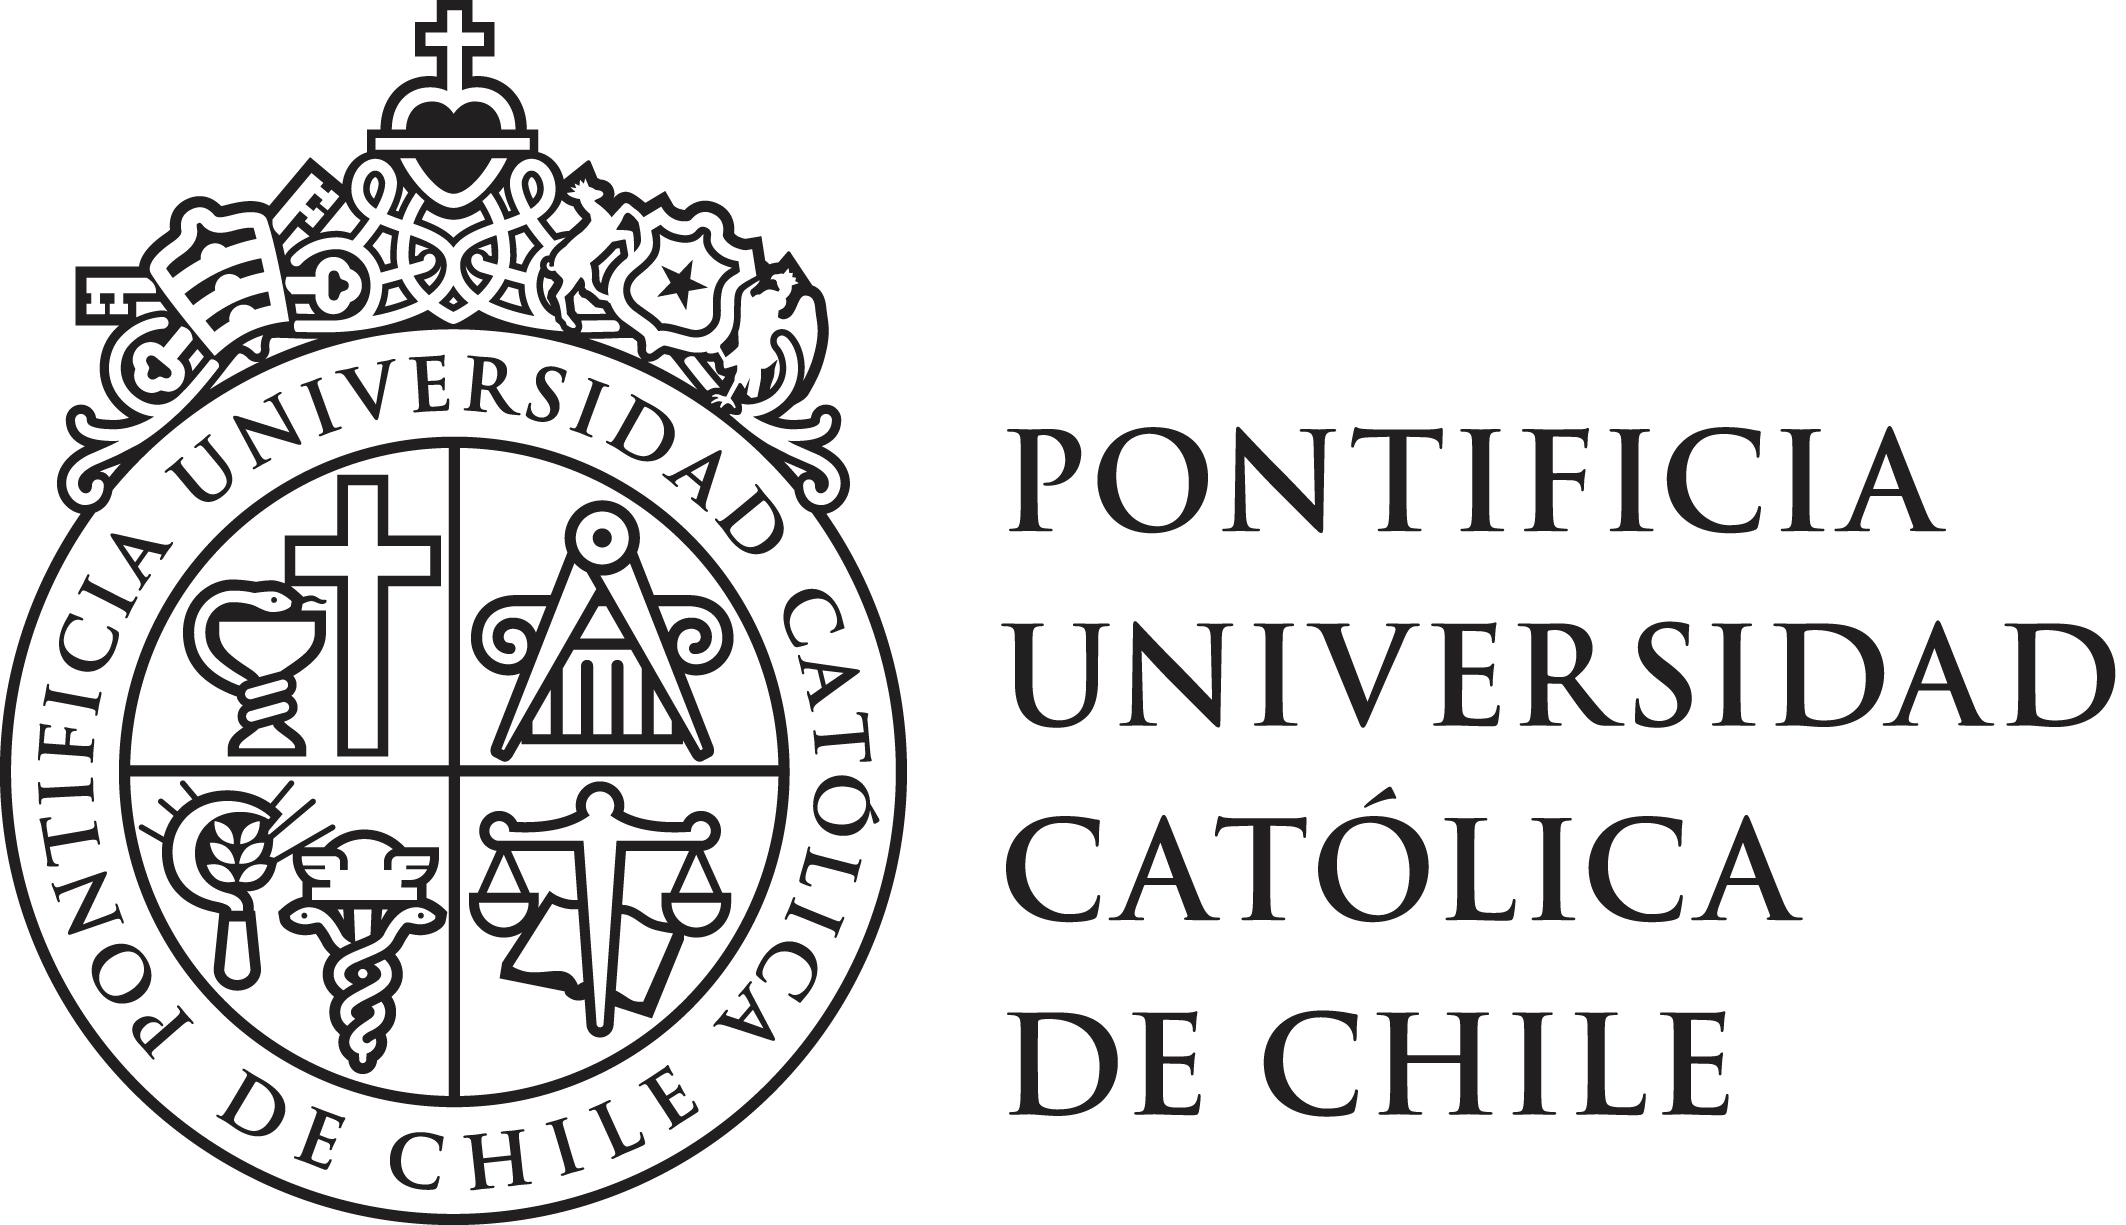

In [1]:
from IPython.display import Image

Image(filename='UC-NEGRO-01.jpg', width=200)

# PROCESAMIENTO DE LENGUAJE NATURAL

- Versiones de librerías, python 3.8.10

- numpy 1.20.3
- nltk 3.7
- rank_bm25 0.2.2

In [1]:
class InvertedIndex:

    def __init__(self):
        self.index = dict()

    def __contains__(self, item):
        return item in self.index

    def __getitem__(self, item):
        return self.index[item]

    def add(self, word, docid):
        if word in self.index:
            if docid in self.index[word]:
                self.index[word][docid] += 1
            else:
                self.index[word][docid] = 1
        else:
            d = dict()
            d[docid] = 1
            self.index[word] = d

    #frequency of word in document, Tf
    def get_document_frequency(self, word, docid):
        if word in self.index:
            if docid in self.index[word]:
                return self.index[word][docid]
            else:
                raise LookupError('%s not in document %s' % (str(word), str(docid)))
        else:
            raise LookupError('%s not in index' % str(word))

    #number of documents that contain word, ni
    def get_index_frequency(self, word):
        if word in self.index:
            return len(self.index[word])
        else:
            raise LookupError('%s not in index' % word)


class DocumentLengthTable:

    def __init__(self):
        self.table = dict()

    def __len__(self):
        return len(self.table)

    def add(self, docid, length):
        self.table[docid] = length

    def get_length(self, docid): #dl
        if docid in self.table:
            return self.table[docid]
        else:
            raise LookupError('%s not found in table' % str(docid))

    def get_average_length(self): #avgdl
        sum = 0 
        for length in self.table.values():
            sum += length
        return float(sum) / float(len(self.table))


def build_data_structures(corpus):
    idx = InvertedIndex()
    dlt = DocumentLengthTable()
    for docid in corpus:

        #build inverted index, sequential scan
        for word in corpus[docid]:
            idx.add(str(word), str(docid))

        #build document length table
        length = len(corpus[str(docid)])
        dlt.add(docid, length)
    return idx, dlt

In [2]:
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer, sent_tokenize
from nltk.stem import WordNetLemmatizer

# Load stop-words
stop_words = set(stopwords.words('english'))

# Initialize tokenizer
# It's also possible to try with a stemmer or to mix a stemmer and a lemmatizer
tokenizer = RegexpTokenizer('[\'a-zA-Z]+')

# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()

def tokenize(document):
    words = []

    for sentence in sent_tokenize(document):
        tokens = [lemmatizer.lemmatize(t.lower()) for t in tokenizer.tokenize(sentence) if t.lower() not in stop_words and len(t) > 2]
        words += tokens

    return words


In [3]:
import re


class CorpusParser:

    def __init__(self, filename):
        self.filename = filename
        self.regex = re.compile('^#\s*\d+')
        self.corpus = dict()

    def parse(self):
        with open(self.filename) as f:
            s = ''.join(f.readlines())
        blobs = s.split('#')[1:]
        for doc in blobs:
            text = doc.split()
            docid = text.pop(0)
            words = tokenize(doc)
            self.corpus[docid] = words

    def get_corpus(self):
        return self.corpus


In [4]:
from math import log

k1 = 1.2
k2 = 100
b = 0.75
R = 0.0


def score_BM25(n, f, qf, r, N, dl, avdl):
    K = compute_K(dl, avdl)
    first = log( ( (r + 0.5) / (R - r + 0.5) ) / ( (n - r + 0.5) / (N - n - R + r + 0.5)) )
    second = ((k1 + 1) * f) / (K + f)
    third = ((k2+1) * qf) / (k2 + qf)
    return first * second * third


def compute_K(dl, avdl):
    return k1 * ((1-b) + b * (float(dl)/float(avdl)) )


In [5]:
def run_query(index, dlt, query):
        query_result = dict()
        query_words = tokenize(query)
        for term in query_words:
            if term in index:
                doc_dict = index[term] # retrieve index entry
                for docid, freq in doc_dict.items(): #for each document and its word frequency
                    score = score_BM25(n=len(doc_dict), f=freq, qf=1, r=0, N=len(dlt), dl=dlt.get_length(docid), avdl=dlt.get_average_length()) # calculate score
                    if docid in query_result: #this document has already been scored once
                        query_result[docid] += score
                    else:
                        query_result[docid] = score
        return query_result
    

In [6]:
cp = CorpusParser(filename='corpus.txt')
cp.parse()
corpus = cp.get_corpus()
index, dlt = build_data_structures(corpus)

In [7]:
results = run_query(index, dlt, 'technical reports of the acm')
sorted_results = dict(sorted(results.items(), key=lambda item:item[1], reverse=True))

In [8]:
sorted_results

{'1086': 10.433949617811995,
 '1205': 10.433949617811995,
 '3160': 7.432146001767313,
 '1755': 7.333074152250927,
 '890': 6.977090230228319,
 '2479': 6.764632049818148,
 '1771': 6.6785328086382005,
 '254': 6.603175415133218,
 '2154': 6.522801024373269,
 '1025': 6.4923093674946815,
 '3197': 6.359633678576809,
 '231': 6.329616271070884,
 '1770': 6.18690489936923,
 '1120': 6.149079286928533,
 '3195': 6.0474425149648585,
 '177': 5.817234233578342,
 '768': 5.817234233578342,
 '3161': 5.817234233578342,
 '1796': 5.73979489452791,
 '248': 5.726190230590009,
 '2852': 5.681485443011152,
 '2689': 5.674953920844127,
 '2607': 5.664390223269911,
 '767': 5.5909410702647975,
 '1397': 5.57374234680908,
 '1238': 5.518715574729853,
 '1194': 5.518121207076675,
 '1476': 5.297022933345598,
 '2303': 5.250527717312686,
 '599': 5.175302610279826,
 '947': 5.175302610279826,
 '985': 5.175302610279826,
 '2538': 5.151636940442143,
 '584': 5.098197254384161,
 '147': 5.023355711941708,
 '196': 5.023355711941708,
 '

Usaremos una librería llamada rank_bm25

> python3 -m pip install rank_bm25

In [9]:
from rank_bm25 import BM25Okapi

corpus = [
    "Hello there good man!",
    "It is quite windy in London",
    "How is the weather today?"
]

tokenized_corpus = [tokenize(doc) for doc in corpus]
bm25 = BM25Okapi(tokenized_corpus)

In [10]:
tokenized_corpus

[['hello', 'good', 'man'], ['quite', 'windy', 'london'], ['weather', 'today']]

In [11]:
query = "windy London"
tokenized_query = tokenize(query)

doc_scores = bm25.get_scores(tokenized_query)
result = bm25.get_top_n(tokenized_query, corpus, n=2)

print(result)

['It is quite windy in London', 'How is the weather today?']


Para otras configuraciones ver: https://github.com/dorianbrown/rank_bm25